In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator

In [2]:
N = 4000
size = 64
labels = np.random.randint(2, size = N)
imgs = np.zeros((size, size, N))


In [3]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_blob_img(length=size, big = True, big_blob_size=8, big_blob_range=2)
    elif labels[i] == 1:
        x = generator.generate_blob_img(length=size, big = False)
    imgs[:,:,i] = x

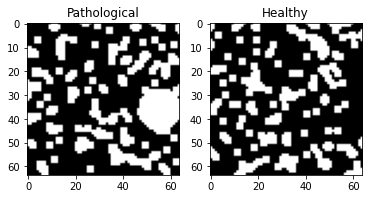

In [4]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,2)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]

ax[0].imshow(path_img, cmap=plt.cm.gray)
ax[1].imshow(healthy_img, cmap=plt.cm.gray)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");

In [5]:
img = measure.label(path_img)
img2 = measure.label(healthy_img)

In [6]:
img = measure.regionprops_table(img, properties=('area', 'eccentricity', 'extent', ))
img2 = measure.regionprops_table(img2, properties=('area', 'eccentricity', 'extent', ))

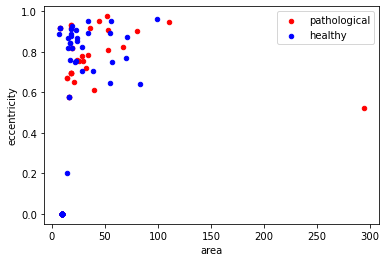

In [9]:
regionprops = pd.DataFrame(img)
regionprops2 = pd.DataFrame(img2)
ax1 = regionprops.plot(kind='scatter', x = 'area', y = 'eccentricity', color = 'r', label = 'pathological')
ax2 = regionprops2.plot(kind='scatter', x = 'area', y = 'eccentricity', color = 'b', label = 'healthy', ax = ax1)

